### Example 4: Burgers' equation

Now that we have seen how to construct the non-linear convection and diffusion examples, we can combine them to form Burgers' equations. We again create a set of coupled equations which are actually starting to form quite complicated stencil expressions, even if we are only using low-order discretisations.

Let's start with the definition fo the governing equations:
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = \nu \; \left(\frac{\partial ^2 u}{\partial x^2} + \frac{\partial ^2 u}{\partial y^2}\right)$$
 
$$ \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = \nu \; \left(\frac{\partial ^2 v}{\partial x^2} + \frac{\partial ^2 v}{\partial y^2}\right)$$

The discretized and rearranged form then looks like this:

\begin{aligned}
u_{i,j}^{n+1} &= u_{i,j}^n - \frac{\Delta t}{\Delta x} u_{i,j}^n (u_{i,j}^n - u_{i-1,j}^n) - \frac{\Delta t}{\Delta y} v_{i,j}^n (u_{i,j}^n - u_{i,j-1}^n) \\
&+ \frac{\nu \Delta t}{\Delta x^2}(u_{i+1,j}^n-2u_{i,j}^n+u_{i-1,j}^n) + \frac{\nu \Delta t}{\Delta y^2} (u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j+1}^n)
\end{aligned}

\begin{aligned}
v_{i,j}^{n+1} &=  v_{i,j}^n - \frac{\Delta t}{\Delta x} u_{i,j}^n (v_{i,j}^n - v_{i-1,j}^n) - \frac{\Delta t}{\Delta y} v_{i,j}^n (v_{i,j}^n - v_{i,j-1}^n) \\
&+ \frac{\nu \Delta t}{\Delta x^2}(v_{i+1,j}^n-2v_{i,j}^n+v_{i-1,j}^n) + \frac{\nu \Delta t}{\Delta y^2} (v_{i,j+1}^n - 2v_{i,j}^n + v_{i,j+1}^n)
\end{aligned}

Great. Now before we look at the Devito implementation, let's re-create the NumPy-based implementation form the original.

In [4]:
from examples.cfd import plot_field, init_hat
import numpy as np
%matplotlib inline

# Some variable declarations
nx = 41
ny = 41
nt = 120
c = 1
dx = 2. / (nx - 1)
dy = 2. / (ny - 1)
sigma = .0009
nu = 0.01
dt = sigma * dx * dy / nu

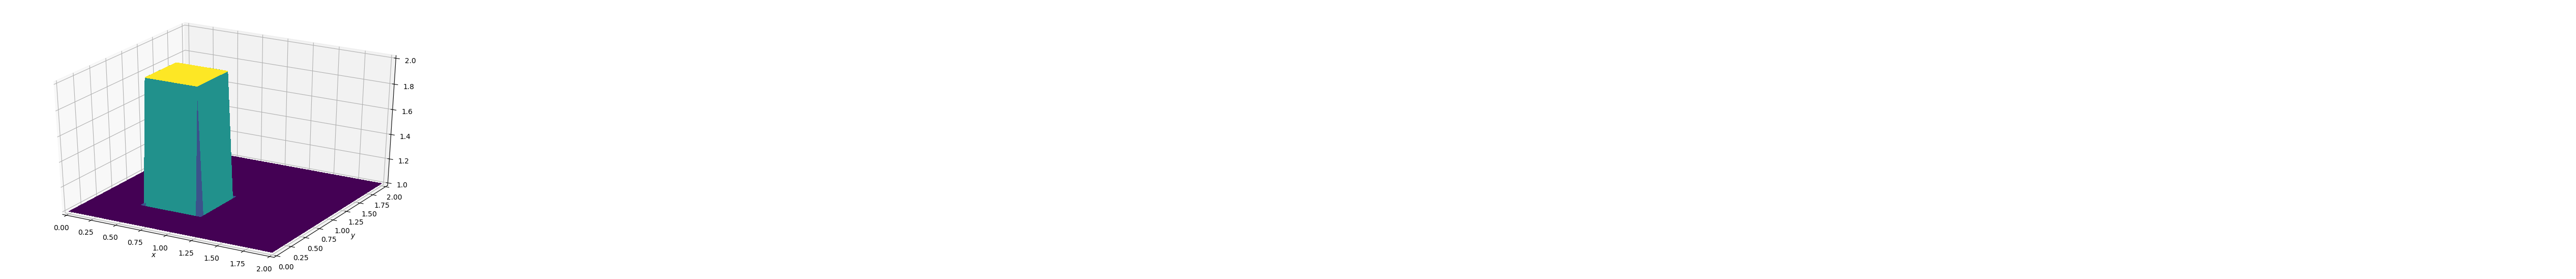

In [5]:
#NBVAL_IGNORE_OUTPUT

# Assign initial conditions
u = np.empty((nx, ny))
v = np.empty((nx, ny))

init_hat(field=u, dx=dx, dy=dy, value=2.)
init_hat(field=v, dx=dx, dy=dy, value=2.)

plot_field(u)

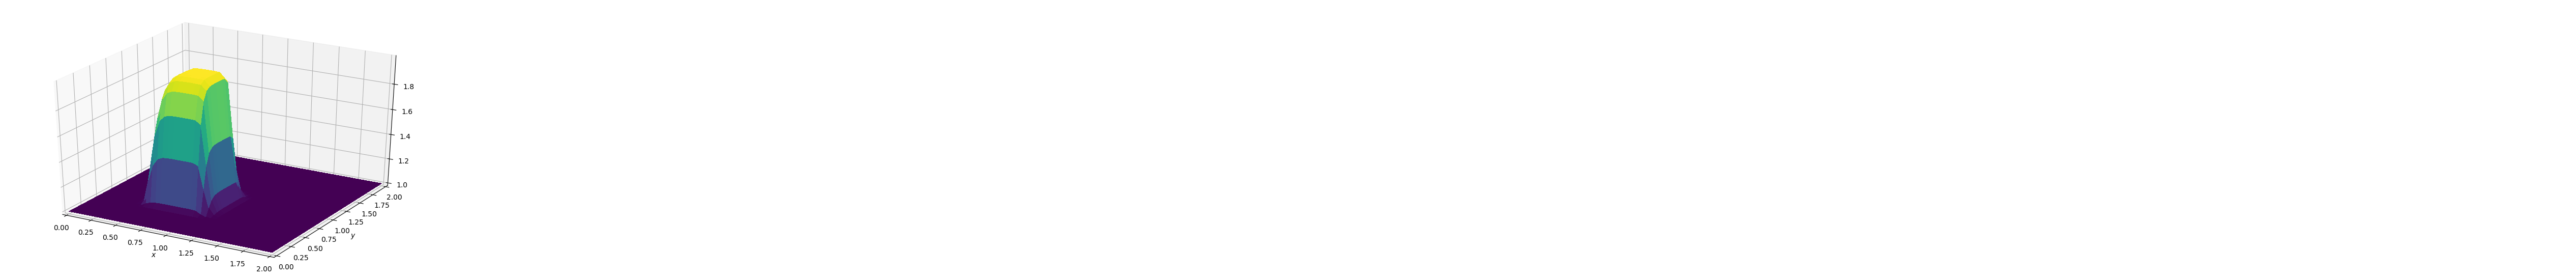

In [6]:
#NBVAL_IGNORE_OUTPUT

for n in range(nt + 1): ##loop across number of time steps
    un = u.copy()
    vn = v.copy()

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     dt / dx * un[1:-1, 1:-1] * 
                     (un[1:-1, 1:-1] - un[1:-1, 0:-2]) - 
                     dt / dy * vn[1:-1, 1:-1] * 
                     (un[1:-1, 1:-1] - un[0:-2, 1:-1]) + 
                     nu * dt / dx**2 * 
                     (un[1:-1,2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + 
                     nu * dt / dy**2 * 
                     (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
    
    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] - 
                     dt / dx * un[1:-1, 1:-1] *
                     (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     dt / dy * vn[1:-1, 1:-1] * 
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) + 
                     nu * dt / dx**2 * 
                     (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     nu * dt / dy**2 *
                     (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]))
     
    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1
    
    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1
    
plot_field(u)

Nice, our wave looks just like the original. Now we shall attempt to write our entire Burgers' equation operator in a single cell - but before we can demonstrate this, there is one slight problem.

The diffusion term in our equation requires a second-order space discretisation on our velocity fields, which we set through the `TimeFunction` constructor for $u$ and $v$. The `TimeFunction` objects will store this dicretisation information and use it as default whenever we use the shorthand notations for derivative, like `u.dxl` or `u.dyl`. For the advection term, however, we want to use a first-order discretisation, which we now have to create by hand when combining terms with different stencil discretisations. To illustrate let's consider the following example: 

In [7]:
from devito import Grid, TimeFunction, first_derivative, left

grid = Grid(shape=(nx, ny), extent=(2., 2.))
x, y = grid.dimensions
t = grid.stepping_dim

u1 = TimeFunction(name='u1', grid=grid, space_order=1)
print("Space order 1:\n%s\n" % u1.dxl)

u2 = TimeFunction(name='u2', grid=grid, space_order=2)
print("Space order 2:\n%s\n" % u2.dxl)

# We use u2 to create the explicit first-order derivative
u1_dx = first_derivative(u2, dim=x, side=left, order=1)
print("Explicit space order 1:\n%s\n" % u1_dx)

Space order 1:
u1(t, x, y)/h_x - u1(t, x - h_x, y)/h_x

Space order 2:
1.5*u2(t, x, y)/h_x + 0.5*u2(t, x - 2*h_x, y)/h_x - 2.0*u2(t, x - h_x, y)/h_x

Explicit space order 1:
u2(t, x, y)/h_x - u2(t, x - h_x, y)/h_x



Ok, so by constructing derivative terms explicitly we again have full control of the spatial discretisation - the power of symbolic computation. Armed with that trick, we can now build and execute our advection-diffusion operator from scratch in one cell.

Operator `Kernel` run in 0.00 s


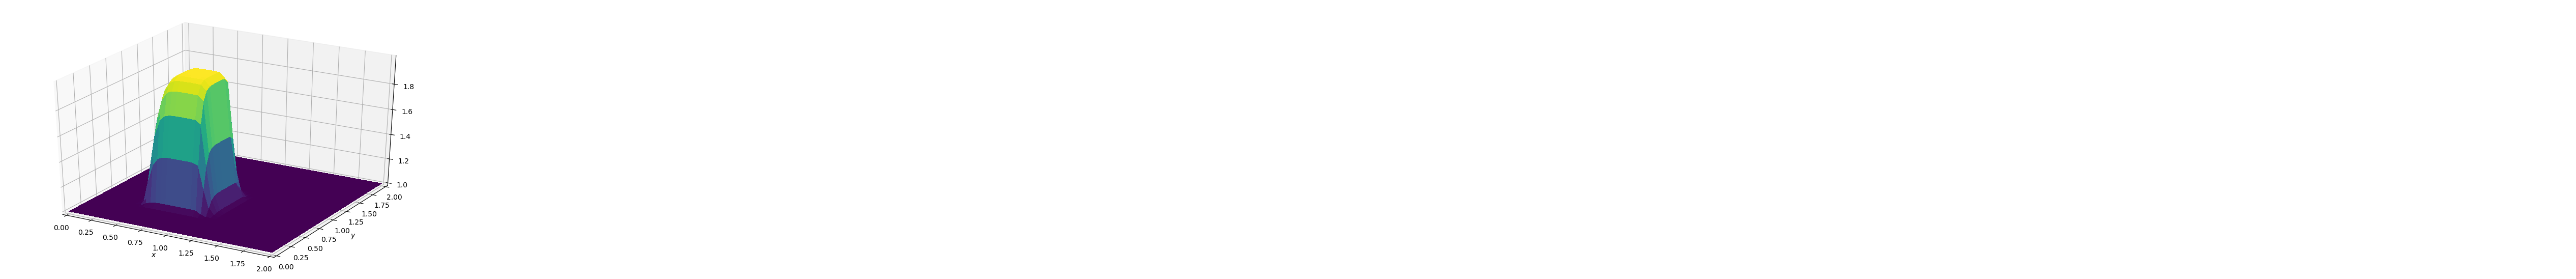

In [8]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator, Constant, Eq, solve

# Define our velocity fields and initialise with hat function
u = TimeFunction(name='u', grid=grid, space_order=2)
v = TimeFunction(name='v', grid=grid, space_order=2)
init_hat(field=u.data[0], dx=dx, dy=dy, value=2.)
init_hat(field=v.data[0], dx=dx, dy=dy, value=2.)

# Write down the equations with explicit backward differences
a = Constant(name='a')
u_dx = first_derivative(u, dim=x, side=left, order=1)
u_dy = first_derivative(u, dim=y, side=left, order=1)
v_dx = first_derivative(v, dim=x, side=left, order=1)
v_dy = first_derivative(v, dim=y, side=left, order=1)
eq_u = Eq(u.dt + u*u_dx + v*u_dy, a*u.laplace, subdomain=grid.interior)
eq_v = Eq(v.dt + u*v_dx + v*v_dy, a*v.laplace, subdomain=grid.interior)

# Let SymPy rearrange our stencils to form the update expressions
stencil_u = solve(eq_u, u.forward)
stencil_v = solve(eq_v, v.forward)
update_u = Eq(u.forward, stencil_u)
update_v = Eq(v.forward, stencil_v)

# Create Dirichlet BC expressions using the low-level API
bc_u = [Eq(u[t+1, 0, y], 1.)]  # left
bc_u += [Eq(u[t+1, nx-1, y], 1.)]  # right
bc_u += [Eq(u[t+1, x, ny-1], 1.)]  # top
bc_u += [Eq(u[t+1, x, 0], 1.)]  # bottom
bc_v = [Eq(v[t+1, 0, y], 1.)]  # left
bc_v += [Eq(v[t+1, nx-1, y], 1.)]  # right
bc_v += [Eq(v[t+1, x, ny-1], 1.)]  # top
bc_v += [Eq(v[t+1, x, 0], 1.)]  # bottom

# Create the operator
op = Operator([update_u, update_v] + bc_u + bc_v)

# Execute the operator for a number of timesteps
op(time=nt, dt=dt, a=nu)

plot_field(u.data[0])